# Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

# Import data and pre-process data

In [2]:
df_LookupTable = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/FinalLookupTable.xlsx')
df_Citypair = pd.read_excel('/home/kamal/Desktop/CAI-2024/DatasetUsed/CityPair.xlsx')
#df_Citypair only contain the departure and arrival hour we need to find the duration of the flight

In [3]:
# Calculate TimeOfFlight
df_Citypair['TimeOfFlight'] = df_Citypair.apply(lambda row: (row['Arrival Hour'] - row['Departure Hour'] + 24) if (row['Arrival Hour'] - row['Departure Hour']) < 0 else (row['Arrival Hour'] - row['Departure Hour']), axis=1)

# Dropping the extra unused columns for making dataframe simple
df_flightTime = df_Citypair.drop(["Date","Departure Hour", "Arrival Hour"], axis=1)

In [4]:
# Function for calculating the average time of flight as well as the number of flights between two cities in a dataset
def calculate_average_time_of_flight(flight_data):
    new_df = flight_data.groupby(['Departure', 'Arrival']).agg(
        TimeOfFlight=('TimeOfFlight', 'mean'),
        Count=('TimeOfFlight', 'count')
    ).reset_index()

    new_df = new_df.sort_values(['Departure', 'Count'], ascending=[True, False])

    return new_df


new_dataframe = calculate_average_time_of_flight(df_flightTime)
new_dataframe = new_dataframe.reset_index(drop=True) #Just to reset the index to avoid confusion

In [5]:
#Function to find the top ten departure from the given airport
def unique_arrival_departure_single(df, airport_name):
    """
    This function takes a pandas DataFrame with 'Departure' and 'Arrival' columns, and the name of an airport.
    It returns a list of unique arrival airports for the specified departure airport.
    """
    departure_airports = df[df['Departure'] == airport_name]['Arrival'].unique()[:15] # Used already sorted dataframe and return first 10 unique value
    airports_remove= ['MYNN','CYYZ','SJU','SKBO','MUHA','MPTO','MDSD'] # To remove the international destinations from the list
    departure_airports = departure_airports.tolist()  # Convert NumPy array to list
    for item in airports_remove:
      if item in departure_airports:
        departure_airports.remove(item)
    return list(departure_airports[:10])

unique_arrival_departure_single(new_dataframe,'FLL')

['ATL', 'EWR', 'LGA', 'JFK', 'BWI', 'CLT', 'DCA', 'IAH', 'DFW', 'PHL']

In [6]:
#This function returns the time taken from departure airport to the arrival airports
def get_time_of_flight(departure, arrival_list, flight_data):
    result_data = pd.DataFrame(columns=['Arrival', 'TimeOfFlight'])
    for arrival in arrival_list:
        filtered_data = flight_data[(flight_data['Departure'] == departure) & (flight_data['Arrival'] == arrival)]
        if not filtered_data.empty:
            time_of_flight = filtered_data['TimeOfFlight'].values[0]
            result_data = pd.concat([result_data, pd.DataFrame({'Arrival': [arrival], 'TimeOfFlight': [time_of_flight]})], ignore_index=True)
    return result_data

departure = 'FLL'
arrival_list = unique_arrival_departure_single(new_dataframe,'FLL')

time_of_flights = get_time_of_flight(departure, arrival_list, df_flightTime)
time_of_flights

,Arrival,TimeOfFlight
0,ATL,2
1,EWR,3
2,LGA,2
3,JFK,2
4,BWI,3
5,CLT,2
6,DCA,3
7,IAH,2
8,DFW,2
9,PHL,2


In [7]:
#This is the function to return the time duration for the flights between the city pairs
def get_time_duration(airports,departure):
    time_of_flights = get_time_of_flight(departure, airports, df_flightTime)
    # Filter the DataFrame to include only rows with the specified airports
    airport_df = time_of_flights[time_of_flights['Arrival'].isin(airports)]

    # Return the list of TimeOfFlight values
    return airport_df['TimeOfFlight'].tolist()

airports_pair_DAB=unique_arrival_departure_single(new_dataframe,'FLL')
get_time_duration(airports_pair_DAB,'FLL')

[2, 3, 2, 2, 3, 2, 3, 2, 2, 2]

In [8]:
def get_other_mean_std(hour, airports):
    # Filter the DataFrame to include only rows with the given hour and specified airports
    airport_hour_df = df_LookupTable[(df_LookupTable['DATE'].dt.hour == hour) & (df_LookupTable['Airport'].isin(airports))]

    # Group the data by airport and hour, and calculate the mean and standard deviation of the 'Other' column
    group_mean_std = airport_hour_df.groupby(['Airport', airport_hour_df['DATE'].dt.hour])['Other'].agg(['mean', 'std']).reset_index()

    # Return a list of tuples, with each tuple containing airport, mean, and std
    return [(airport, mean, std) for airport, mean, std in zip(group_mean_std['Airport'], group_mean_std['mean'], group_mean_std['std'])]

In [9]:
#Function to generate the list of time of flights of the pair airports
def get_other_mean_std(hours, airports):
    result = []

    # Iterate over each airport and corresponding hour
    for airport, hour in zip(airports, hours):
        # Filter the DataFrame to include only rows with the given hour and specified airport
        airport_hour_df = df_LookupTable[(df_LookupTable['DATE'].dt.hour == hour) & (df_LookupTable['Airport'] == airport)]

        # Group the data by airport and hour, and calculate the mean and standard deviation of the 'Other' column
        group_mean_std = airport_hour_df.groupby(['Airport', airport_hour_df['DATE'].dt.hour])['Other'].agg(['mean', 'std']).reset_index()

        # Append the airport, mean, and std to the result list
        result.extend([(airport, mean, std) for airport, mean, std in zip(group_mean_std['Airport'], group_mean_std['mean'], group_mean_std['std'])])

    # Return the result list
    return result

In [16]:
#Function to print the capability of airport at particular hour of the day
def capability_mean_std(airport, hour):
    # Filter the DataFrame to include only rows with the given airport and hour
    airport_hour_df = df_LookupTable[(df_LookupTable['Airport'] == airport) & (df_LookupTable['DATE'].dt.hour == hour)]

    # Check if there is data available
    if airport_hour_df.empty:
        print("No data available for the given airport and hour.")
        return

    # Calculate the mean and standard deviation of the 'Other' column
    mean = airport_hour_df['Other'].mean()
    std = airport_hour_df['Other'].std()

    return mean,std

# Genetic Algorithm with Neural Network

In [11]:
def CapabilityForWholeDayGA(hour_departure,departure_airport,airport_pair):
  time_flight = get_time_duration(airport_pair,departure_airport) # Finding the duration of flight in hours
  hours_arrival=[x+hour_departure for x in time_flight] # Finding the arrival time in the airports
  hours_arrival_final = [num % 24 for num in hours_arrival] #Changing the arrival time into suitable format

  meanDeparture,stdDeparture= capability_mean_std(departure_airport, hour_departure)
  meanRoundoff=round(meanDeparture)
  if meanRoundoff==0:
    meanRoundoff=1
  # Print the mean and standard deviation
  print(f"Capability for departure airport {departure_airport} at hour {hour} is {meanRoundoff} ")


  # Call the function with the hours and airports lists
  result = get_other_mean_std(hours_arrival_final, airport_pair)
  return result,meanRoundoff

In [12]:
# For our experiment we use three different combination of population size and number of generations
# population size of 15 with 5 generations, 30 with 10 generations and 75 with 25 generations
population_size = 15 #15 30 75
num_generations = 5 #5  10 25
#Hyperparameters for our model
crossover_rate = 0.8
mutation_rate = 0.01

In [18]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(31, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output_layer = nn.ModuleList([nn.Linear(64, 1) for _ in range(10)])

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        outputs = [layer(x) for layer in self.output_layer]
        return torch.cat(outputs, dim=1)


def min_max_normalize(data):
    X_min = min(data)
    X_max = max(data)
    normalized_data = [(x - X_min) / (X_max - X_min) for x in data]
    return normalized_data

def extract(result, index):
  # Extract the particular value like std, mean depending upon the passed index
    extracted_data = []
    for item in result:
        extracted_data.append(item[index])
    return extracted_data

def calculate_fitness(chromosome,result,meanCapability):
    # Calculate the fitness using the given formula


    #Penalty on the basis of total number of flights
    rounded_capabilities = []
    for item in result:
      capability = item[1]
      rounded_capability = round(capability)  # Round off to the nearest integer
      if rounded_capability == 0:
          rounded_capability = 1  # Replace zero with 1
      rounded_capabilities.append(rounded_capability)


    totalNumberOfFlights = 0
    #print(rounded_capabilities)

    for flag, element in zip(chromosome, rounded_capabilities):
          if flag == 1:
              totalNumberOfFlights += element

    penalty= 0
    #print(totalNumberOfFlights)

    if totalNumberOfFlights>=meanCapability:
        penalty=1



    # #Different way of using penalty on the basis of number of airports consider
    # num_airport_selected= chromosome.count(1)
    # penalty=0  # This is to restrict the selection of all the airports to maximize the fitness
    # if num_airport_selected > meanCapability:
    #   penalty=1



    p = calculate_popularity(chromosome)
    s = calculate_sum_standard_deviation(chromosome,result)
    c = calculate_capability(chromosome,result)
    # test=0.5 * p + 0.2* c - 0.3 * s-penalty
    # print(f"p={p},s={s} and c={c},penalty={penalty}, score={test}")
    return 0.5 * p + 0.2* c - 0.3 * s- penalty

def calculate_popularity(chromosome):
    # Calculate the popularity of the arrival airports
    popularity_list = min_max_normalize([10,9,8,7,6,5,4,3,2,1])
    popularity=0
    index=0
    position=10
    for bit in chromosome:
        if bit == 1:
            popularity += popularity_list[index]
        index=index+1
    return popularity

def calculate_sum_standard_deviation(chromosome,result):
    # Calculate the sum of standard deviation of the arrival airports
    sum_std = 0
    std_list=extract(result,2)
    std_list=min_max_normalize(std_list)
    #print(std_list)
    index=0
    for bit in chromosome:
        if bit == 1:
            sum_std += std_list[index]    # Add the corresponding standard deviation to the sum
        index+=1
    #print(sum_std)
    return sum_std


def calculate_capability(chromosome,result):
      # Calculate the sum of mean of capabilities of the arrival airports
    sum_capability = 0
    capability_list=extract(result,1)
    capability_list=min_max_normalize(capability_list)
    #print(capability_list)
    index=0
    for bit in chromosome:
        if bit == 1:
            sum_capability += capability_list[index]    # Add the corresponding standard deviation to the sum
        index+=1
    #print(sum_capability)
    return sum_capability


def initialize_population(population_size):
    # Initialize the population randomly with chromosomes of 10 bits
    population = []
    for _ in range(population_size):
        chromosome = [random.choice([0, 1]) for _ in range(10)]
        population.append(chromosome)
    return population

def select_parents(population,result,meanCapability):

    #importing the neural network

    # Create an instance of the Neural Network
    model = NeuralNet()

    # Load the saved model 
    # Use this to load the different Neural Network model which are trained under different number of epochs
    model.load_state_dict(torch.load("/home/kamal/Desktop/CAI-2024/models/model_5.pth"))


    updated_result= [(str(10 - i), *tup[1:]) for i, tup in enumerate(result)]
    data_dict = {}
    for idx, tup in enumerate(updated_result):
        for i, item in enumerate(tup):
            data_dict[f'A{i+1+(idx*3)}'] = item

    data_dict['C'] = meanCapability

    df = pd.DataFrame([data_dict])
    # Convert the DataFrame to a numpy array
    data_array = df.values.astype(np.float32)

    # Convert the numpy array to a PyTorch tensor
    tensor_data = torch.tensor(data_array, dtype=torch.float32).view(-1, 1)

    tensor_data = tensor_data.view(1, -1)

    with torch.no_grad():
      output = model(tensor_data)
      output = torch.where(output < 0, torch.tensor(0.0), output)
      #print(output)
      output_binary = torch.round(output)
      parent_nn=output_binary.flatten().tolist()

    # Perform tournament selection to select parents
    parent_pool = []
    tournament_size = 2

    # #Adding the output of neural network to parent pool
    # for i in range(int(len(population)/2)):
    #   parent_pool.append(parent_nn)

    # Perform tournament selection until parent pool is filled
    while len(parent_pool) < len(population):
        participants = random.sample(population, tournament_size)

        # Calculate fitness values for the participants
        fitness_values = [calculate_fitness(chromosome,result,meanCapability) for chromosome in participants]

        # Select the chromosome with the highest fitness value
        winner = participants[fitness_values.index(max(fitness_values))]

        parent_pool.append(winner)



    best_parent=find_best_chromosome(parent_pool,result,meanCapability)
    sorted_parent_pool=sort_chromosome(parent_pool,result,meanCapability)
    if calculate_fitness(best_parent,result,meanCapability) < calculate_fitness(parent_nn,result,meanCapability):
        # Find the startpoint of the list
        startpoint = len(sorted_parent_pool) // 2
        for i in range(startpoint,len(sorted_parent_pool),1):
          sorted_parent_pool[i]= parent_nn



    #random.shuffle(sorted_parent_pool)
    return parent_pool

def crossover(parent1, parent2):
    # Perform crossover between two parents to create offspring
    # Perform single-point crossover between two parents to create offspring
    crossover_point = random.randint(1, len(parent1) - 1)  # Select a random crossover point

    # Create offspring
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]

    return offspring1, offspring2

def mutate(chromosome):
    # Perform mutation on the chromosome
    mutated_chromosome = chromosome.copy()  # Create a copy of the chromosome

    # Iterate through each bit in the chromosome
    for i in range(len(mutated_chromosome)):
        if random.random() < mutation_rate:
            # Flip the bit at the current position
            mutated_chromosome[i] = 0 if chromosome[i] == 1 else 1

    # Return the mutated chromosome
    return mutated_chromosome


def find_best_chromosome(parents_list,result,meanCapability):
  best_reward=0
  best_parents= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

  for parents in parents_list:
      reward = calculate_fitness(parents, result, meanCapability)
      if reward>best_reward:
        best_reward=reward
        best_parents=parents
  #     print(f"Combination: {combination}, Reward: {reward}")
  # print()
  # print()
  # print(f"Combination: {best_combination}, Reward: {best_reward}")
  return best_parents




def sort_chromosome(parents_list, result, meanCapability):

    # Calculate the rewards for each parent and create a list of tuples (parent, reward)
    parents_with_rewards = [(parents, calculate_fitness(parents, result, meanCapability)) for parents in parents_list]

    # Sort the list of parents by reward in descending order
    sorted_parents = sorted(parents_with_rewards, key=lambda x: x[1], reverse=True)

    # Extract the sorted parents from the list of tuples
    sorted_parents_list = [parents for parents, _ in sorted_parents]

    # Return the sorted list of parents
    #print(sorted_parents_list)
    return sorted_parents_list



def calculate_numberOfFlights(chromosome,result):
    # Calculate the fitness using the given formula


    #Penalty on the basis of total number of flights
    rounded_capabilities = []
    for item in result:
      capability = item[1]
      rounded_capability = round(capability)  # Round off to the nearest integer
      if rounded_capability == 0:
          rounded_capability = 1  # Replace zero with 1
      rounded_capabilities.append(rounded_capability)


    totalNumberOfFlights = 0
    #print(rounded_capabilities)

    for flag, element in zip(chromosome, rounded_capabilities):
          if flag == 1:
              totalNumberOfFlights += element

    penalty= 0
    return totalNumberOfFlights

In [19]:
def GeneticAlgorithm(result,meanCapability):
    # Initialize population
    population = initialize_population(population_size)

    # Main loop for generations
    for _ in range(num_generations):
        # Calculate fitness for each chromosome in the population
        fitness_values = [calculate_fitness(chromosome,result,meanCapability) for chromosome in population]

        # Select parents for reproduction
        parents = select_parents(population,result,meanCapability)

        # Create offspring through crossover and mutation
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            if random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1, parent2
            offspring.append(child1)
            offspring.append(child2)

        # Apply mutation to introduce diversity
        for chromosome in offspring:
            for i in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[i] = 1 - chromosome[i]

        # Calculate fitness for the offspring
        offspring_fitness = [calculate_fitness(chromosome,result,meanCapability) for chromosome in offspring]

        # Replace the least fit individuals in the population with the offspring
        combined_population = population + offspring
        combined_fitness = fitness_values + offspring_fitness
        sorted_population = [chromosome for _, chromosome in sorted(zip(combined_fitness, combined_population), reverse=True)]
        population = sorted_population[:population_size]


    # Select the best chromosome based on fitness as the solution
    #print(population)
    best_chromosome = max(population, key=lambda chromosome: calculate_fitness(chromosome, result,meanCapability))
    return best_chromosome

In [23]:
departure_airport='DAB'
top_ten_airports_pair=unique_arrival_departure_single(new_dataframe,departure_airport)
hoursBetweenDeparture=1
reward_list=[] #list of the fitness score
numberOfFlights_list=[] #list of the number of flights
best_combination_list=[] #list of the selection and rejection of top ten airports
random.seed(42)
for hour in range(0,24,hoursBetweenDeparture):
  result,meanCapability= CapabilityForWholeDayGA(hour,departure_airport,top_ten_airports_pair)
  best_chromosome=GeneticAlgorithm(result,meanCapability)
  best_combination_list.append(best_chromosome)
  reward=calculate_fitness(best_chromosome,result,meanCapability)
  reward_list.append(reward)
  numberOfFlights=calculate_numberOfFlights(best_chromosome,result)
  numberOfFlights_list.append(numberOfFlights)

Capability for departure airport DAB at hour 0 is 3 
Capability for departure airport DAB at hour 1 is 2 
Capability for departure airport DAB at hour 2 is 1 
Capability for departure airport DAB at hour 3 is 1 
Capability for departure airport DAB at hour 4 is 1 
Capability for departure airport DAB at hour 5 is 2 
Capability for departure airport DAB at hour 6 is 7 
Capability for departure airport DAB at hour 7 is 14 
Capability for departure airport DAB at hour 8 is 26 
Capability for departure airport DAB at hour 9 is 31 
Capability for departure airport DAB at hour 10 is 33 
Capability for departure airport DAB at hour 11 is 45 
Capability for departure airport DAB at hour 12 is 44 
Capability for departure airport DAB at hour 13 is 33 
Capability for departure airport DAB at hour 14 is 37 
Capability for departure airport DAB at hour 15 is 40 
Capability for departure airport DAB at hour 16 is 43 
Capability for departure airport DAB at hour 17 is 26 
Capability for departure ai

# Result interpretation

In [21]:
best_combination_list

[[1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [1, 0, 1, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
 [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]]

In [22]:
reward_list

[0.5200942989242148,
 1.0157274578574764,
 1.2558777353723665,
 0.9223428014420292,
 1.032948956051916,
 1.076213860201277,
 1.009974551403479,
 1.373598660845309,
 1.6055405356739834,
 1.42701268705598,
 1.5234250430896528,
 1.5807709958339264,
 1.6161298617676345,
 1.6625062624403475,
 1.6680606518096819,
 1.5380068740095632,
 1.7812056520350839,
 1.7621371334305782,
 1.8264376096824457,
 1.9412766990841255,
 1.7132411280496216,
 2.0397946384033108,
 1.2813925374065616,
 1.1597397121914435]

In [26]:
# fitness score for different models
# This can be achieved by changing the parameters above in the code


# This is the fitness score for the genetic algorithm having population size of 15, generation of 5 accelerated by NN model trained for 5 epochs
# NN model replace the parents in the pool randomly
fs_15_5_fs_5_R=[0.6212091186554578,1.02397442857096, 1.2558777353723665, 0.9739584857127719, 1.0438439445776266, 1.076213860201277, 1.2816308118970696, 1.4627281333022493, 1.4600553321354868, 1.9050611430673212, 1.6427424640798987, 1.6717098418258187, 1.7166301765771217, 1.5651131842664918, 1.8263144254228934, 1.7857338354471781, 1.887810210446232, 1.7621371334305782, 1.9375487207935573, 1.757256073620589, 1.797803463541038, 2.1478911685364057, 1.605866486244734, 1.4421401000764351]


# This is the fitness score for the genetic algorithm having population size of 15, generation of 5 accelerated by NN model trained for 5 epochs
# NN model replace the weak parents by sorting them first.
fs_15_5_fs_5_S=[0.5200942989242148, 1.0157274578574764, 1.2558777353723665, 0.9223428014420292, 1.032948956051916, 1.076213860201277, 1.009974551403479, 1.373598660845309, 1.6055405356739834, 1.42701268705598, 1.5234250430896528, 1.5807709958339264, 1.6161298617676345, 1.6625062624403475, 1.6680606518096819, 1.5380068740095632, 1.7812056520350839, 1.7621371334305782, 1.8264376096824457, 1.9412766990841255, 1.7132411280496216, 2.0397946384033108, 1.2813925374065616, 1.1597397121914435]

#This for vanilla genetic model with population size 75 and generation of 25 whic is obtained from file GeneticAlgorithm.ipynb
fs_75_25=[0.7820671261087556, 1.02397442857096, 1.2558777353723665, 0.9739584857127719, 1.0438439445776266, 1.076213860201277, 1.3653531895322877, 1.6369255557279538, 1.7153860436956612, 1.9050611430673212, 1.7073611385249905, 1.7828209529369303, 1.8010741154364363, 1.6625062624403475, 1.8263144254228934, 1.8968449465582893, 1.9977713324695703, 1.7621371334305782, 1.9681793514241877, 1.9412766990841255, 1.9011984989399688, 2.1478911685364057, 1.6198213401480035, 1.497720083380415]



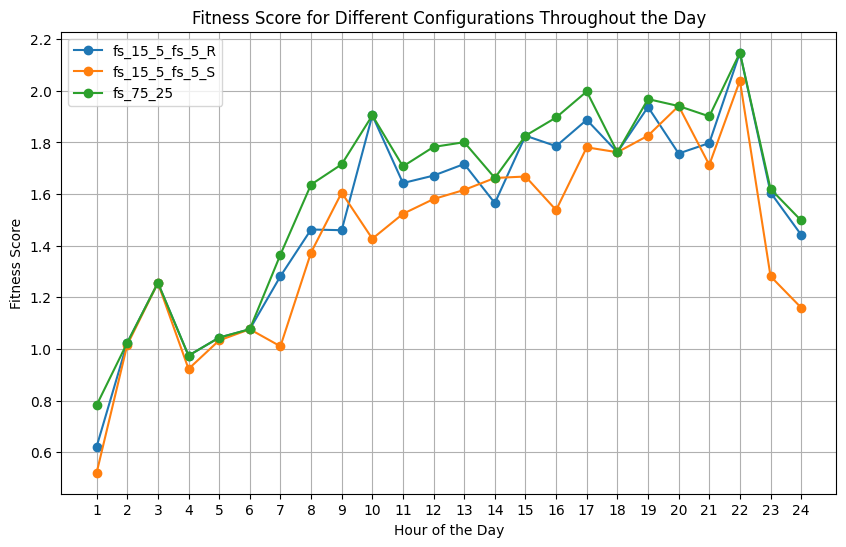

In [28]:
# Define the hours of the day for the x-axis
hours_of_day = list(range(1, 25))

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(hours_of_day, fs_15_5_fs_5_R, label='fs_15_5_fs_5_R', marker='o')
plt.plot(hours_of_day, fs_15_5_fs_5_S, label='fs_15_5_fs_5_S', marker='o')
# plt.plot(hours_of_day, fs_15_5_fs_5_SS, label='fs_15_5_fs_5_SS', marker='o')
plt.plot(hours_of_day, fs_75_25, label='fs_75_25', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Fitness Score')
plt.title('Fitness Score for Different Configurations Throughout the Day')
plt.legend()
plt.grid(True)
plt.xticks(hours_of_day)
plt.show()

In [30]:
#Combination list for the different models

 # For genetic algorithm 75 population and 25 generation whic is obtained from file GeneticAlgorithm.ipynb
genetic = [[1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 1, 0, 0]]



# For the genetic algorithm having population size of 15, generation of 5 accelerated by NN model trained for 5 epochs
# NN model replace the parents in the pool randomly
random= [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 0]]

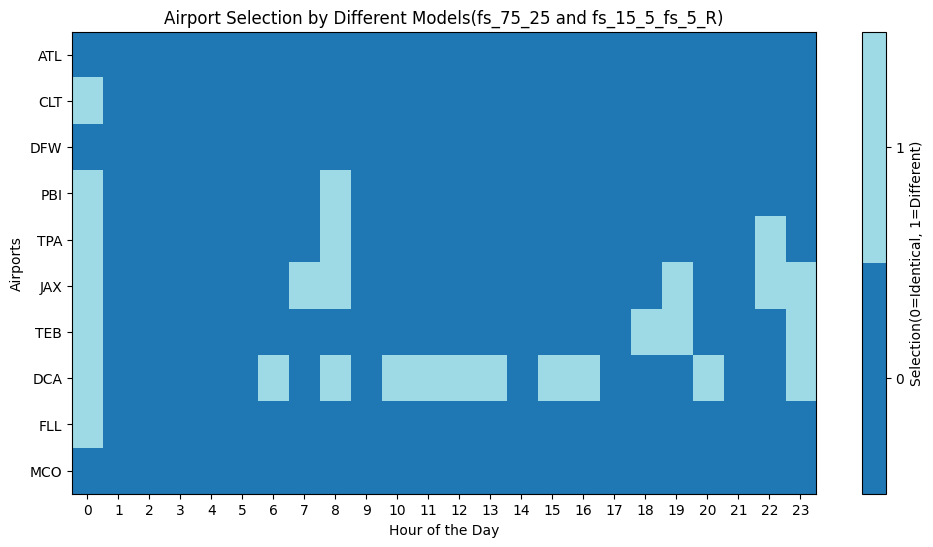

In [31]:
hours = list(range(24))  # Hours of the day

# Airport names
airport_names = ['ATL', 'CLT', 'DFW', 'PBI', 'TPA', 'JAX', 'TEB', 'DCA', 'FLL', 'MCO']

# Creating a categorical heatmap
data = np.zeros((len(airport_names), len(hours)))

for i, airport_name in enumerate(airport_names):
    for j in range(len(hours)):
        if random[j][i] == 0  and genetic[j][i] == 0:
            data[i][j] = 0
        elif random[j][i] == 0 and  genetic[j][i] == 1:
          data[i][j]=1
        elif random[j][i] == 1 and genetic[j][i] == 0:
          data[i][j] = 1
        else:
          data[i][j] = 0

plt.figure(figsize=(12, 6))
plt.imshow(data, cmap='tab20', aspect='auto')

plt.xlabel('Hour of the Day')
plt.ylabel('Airports')
plt.title('Airport Selection by Different Models(fs_75_25 and fs_15_5_fs_5_R)')
plt.xticks(range(len(hours)), hours)
plt.yticks(range(len(airport_names)), airport_names)
# cbar=plt.colorbar(label='Frequency Selection')
# cbar.set_ticks([0, 1, 2, 3])
# Create a colorbar with custom ticks and boundaries
cbar = plt.colorbar(ticks=[0, 1 ], boundaries=[-0.5, 0.5, 1.5], label='Selection(0=Identical, 1=Different)')

plt.show()